In [10]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [11]:
sys.path.append(os.path.abspath(os.path.join('..')))

In [12]:
from NeuralNetwork.Network import Network
from NeuralNetwork.Layers.Input import Input
from NeuralNetwork.Layers.RNN import RNN
from NeuralNetwork.Layers.GRU import GRU
from NeuralNetwork.Layers.LSTM import LSTM
from NeuralNetwork.Losses.MSE import MSE
from NeuralNetwork.Activations.Tanh import Tanh
from NeuralNetwork.Metrics import Metric, Plot

In [13]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Предобработка данных

## Загрузка данных

In [14]:
df = pd.read_csv('Steel_industry_data.csv')
df.index = pd.to_datetime(df['date'])
df = df.drop(columns=['date'])
rows, columns = df.shape

## Описание данных

In [15]:
df.head()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
date,,,,,,,,,,
2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
2018-01-01 01:15:00,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


In [16]:
df.columns

Index(['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
       'WeekStatus', 'Day_of_week', 'Load_Type'],
      dtype='object')

In [17]:
df.dtypes

Usage_kWh                               float64
Lagging_Current_Reactive.Power_kVarh    float64
Leading_Current_Reactive_Power_kVarh    float64
CO2(tCO2)                               float64
Lagging_Current_Power_Factor            float64
Leading_Current_Power_Factor            float64
NSM                                       int64
WeekStatus                               object
Day_of_week                              object
Load_Type                                object
dtype: object

In [18]:
object_columns = df.columns[(df.dtypes == object)]
numeric_columns = df.columns[(df.dtypes != object)]

In [19]:
for column in object_columns:
    print(f"{column}: ")
    print(df[column].unique())

WeekStatus: 
['Weekday' 'Weekend']
Day_of_week: 
['Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday']
Load_Type: 
['Light_Load' 'Medium_Load' 'Maximum_Load']


In [20]:
params = pd.DataFrame()
params.index = ['Количество', '% пропусков', 'Мощность', 'Мода', 'Частота']
for column in object_columns:
    params[column] = [len(df[column]), df[column].isna().sum() * 100 / len(df[column]), df[column].nunique(), df[column].mode().values[0], df[column].value_counts()[df[column].mode().values[0]]]

params = params.style.apply(lambda x: ["background-color:tomato" if i==1 else "" for i in x], axis=1, subset=(['Мощность'], slice(None))).apply(lambda x: ["background-color:limegreen" if i!=1 else "" for i in x], axis=1, subset=(['Мощность'], slice(None))).apply(lambda x: ["background-color:tomato" if i>=60 else "" for i in x], axis=1, subset=(['% пропусков'], slice(None))).apply(lambda x: ["background-color:steelblue" if i<60 and i >= 30 else "" for i in x], axis=1, subset=(['% пропусков'], slice(None))).apply(lambda x: ["background-color:limegreen" if i<30 else "" for i in x], axis=1, subset=(['% пропусков'], slice(None)))
params

,WeekStatus,Day_of_week,Load_Type
Количество,35040,35040,35040
% пропусков,0.000000,0.000000,0.000000
Мощность,2,7,3
Мода,Weekday,Monday,Light_Load
Частота,25056,5088,18072


In [21]:
params = pd.DataFrame()
params.index = ['Количество', '% пропусков', 'Минимум', 'Среднее', 'Максимум', 'Стандартное отклонение', 'Мощность', 'Первый квартиль', 'Медиана', 'Третий квартиль', 'IQR']
for column in numeric_columns:
    params[column] = [len(df[column]), df[column].isna().sum() * 100 / len(df[column]), df[column].min(), df[column].mean(), df[column].max(), df[column].std(), df[column].nunique(), df[column].quantile(0.25), df[column].quantile(0.5), df[column].quantile(0.75), df[column].quantile(0.25) - df[column].quantile(0.75)]

params = params.style.apply(lambda x: ["background-color:tomato" if i==1 else "" for i in x], axis=1, subset=(['Мощность'], slice(None))).apply(lambda x: ["background-color:limegreen" if i!=1 else "" for i in x], axis=1, subset=(['Мощность'], slice(None))).apply(lambda x: ["background-color:tomato" if i>=60 else "" for i in x], axis=1, subset=(['% пропусков'], slice(None))).apply(lambda x: ["background-color:steelblue" if i<60 and i >= 30 else "" for i in x], axis=1, subset=(['% пропусков'], slice(None))).apply(lambda x: ["background-color:limegreen" if i<30 else "" for i in x], axis=1, subset=(['% пропусков'], slice(None)))
params

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM
Количество,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
% пропусков,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Минимум,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Среднее,27.386892,13.035384,3.870949,0.011524,80.578056,84.367870,42750.000000
Максимум,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000
Стандартное отклонение,33.444380,16.306000,7.424463,0.016151,18.921322,30.456535,24940.534317
Мощность,3343.000000,1954.000000,768.000000,8.000000,5079.000000,3366.000000,96.000000
Первый квартиль,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000
Медиана,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000
Третий квартиль,51.237500,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000


## Распределения

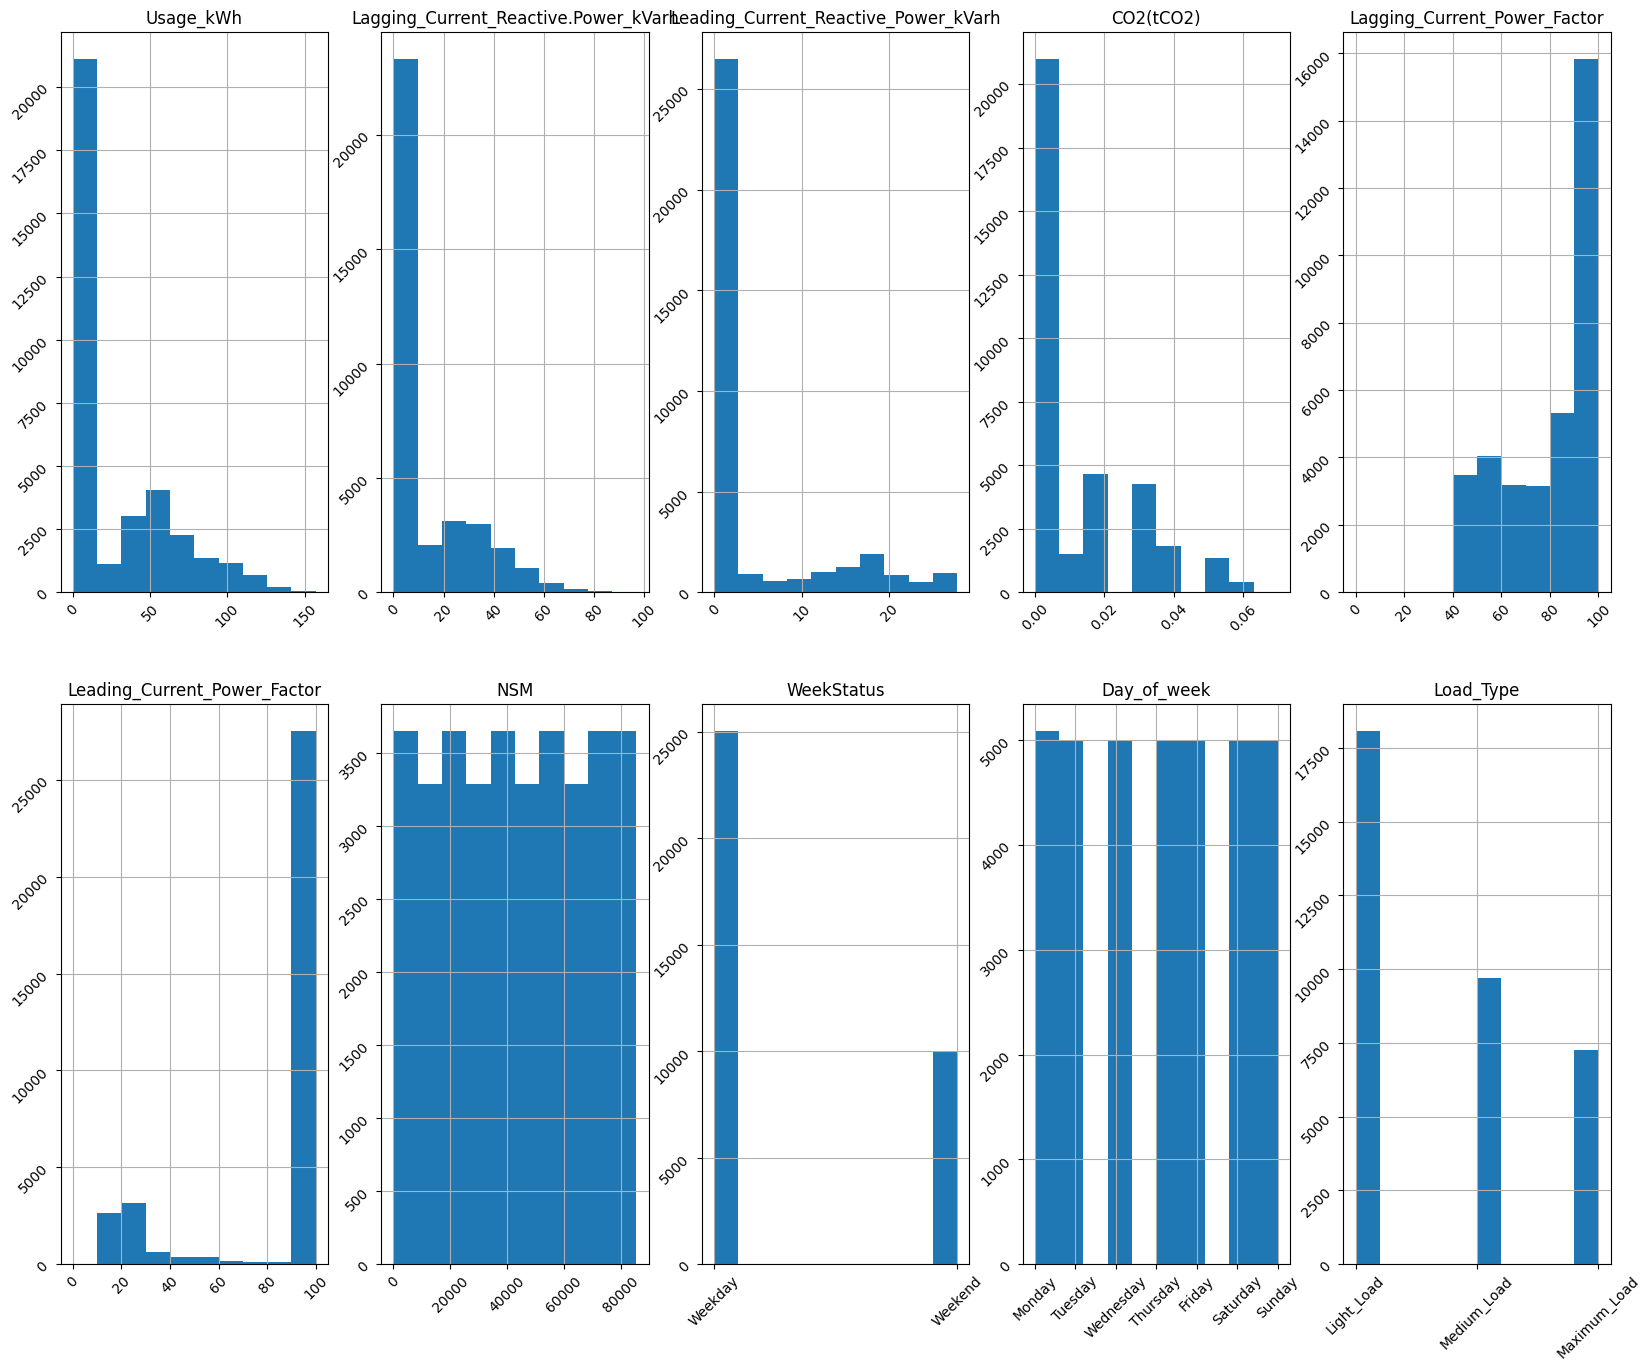

In [22]:
if columns % 5 == 0:
    f, ax = plt.subplots(int(columns // 5), 5, figsize=(20,int(columns // 5) * 8))
else:
    f, ax = plt.subplots(int(columns // 5) + 1, 5, figsize=(20,(int(columns // 5) + 1) * 8))

i = 0
j = 0
for column in df.columns:
    if j == 5:
        j = 0
        i += 1
    df[column].hist(ax=ax[i, j])
    ax[i, j].set_title(column)
    ax[i, j].tick_params(labelrotation=45)
    j += 1

## Временные ряды

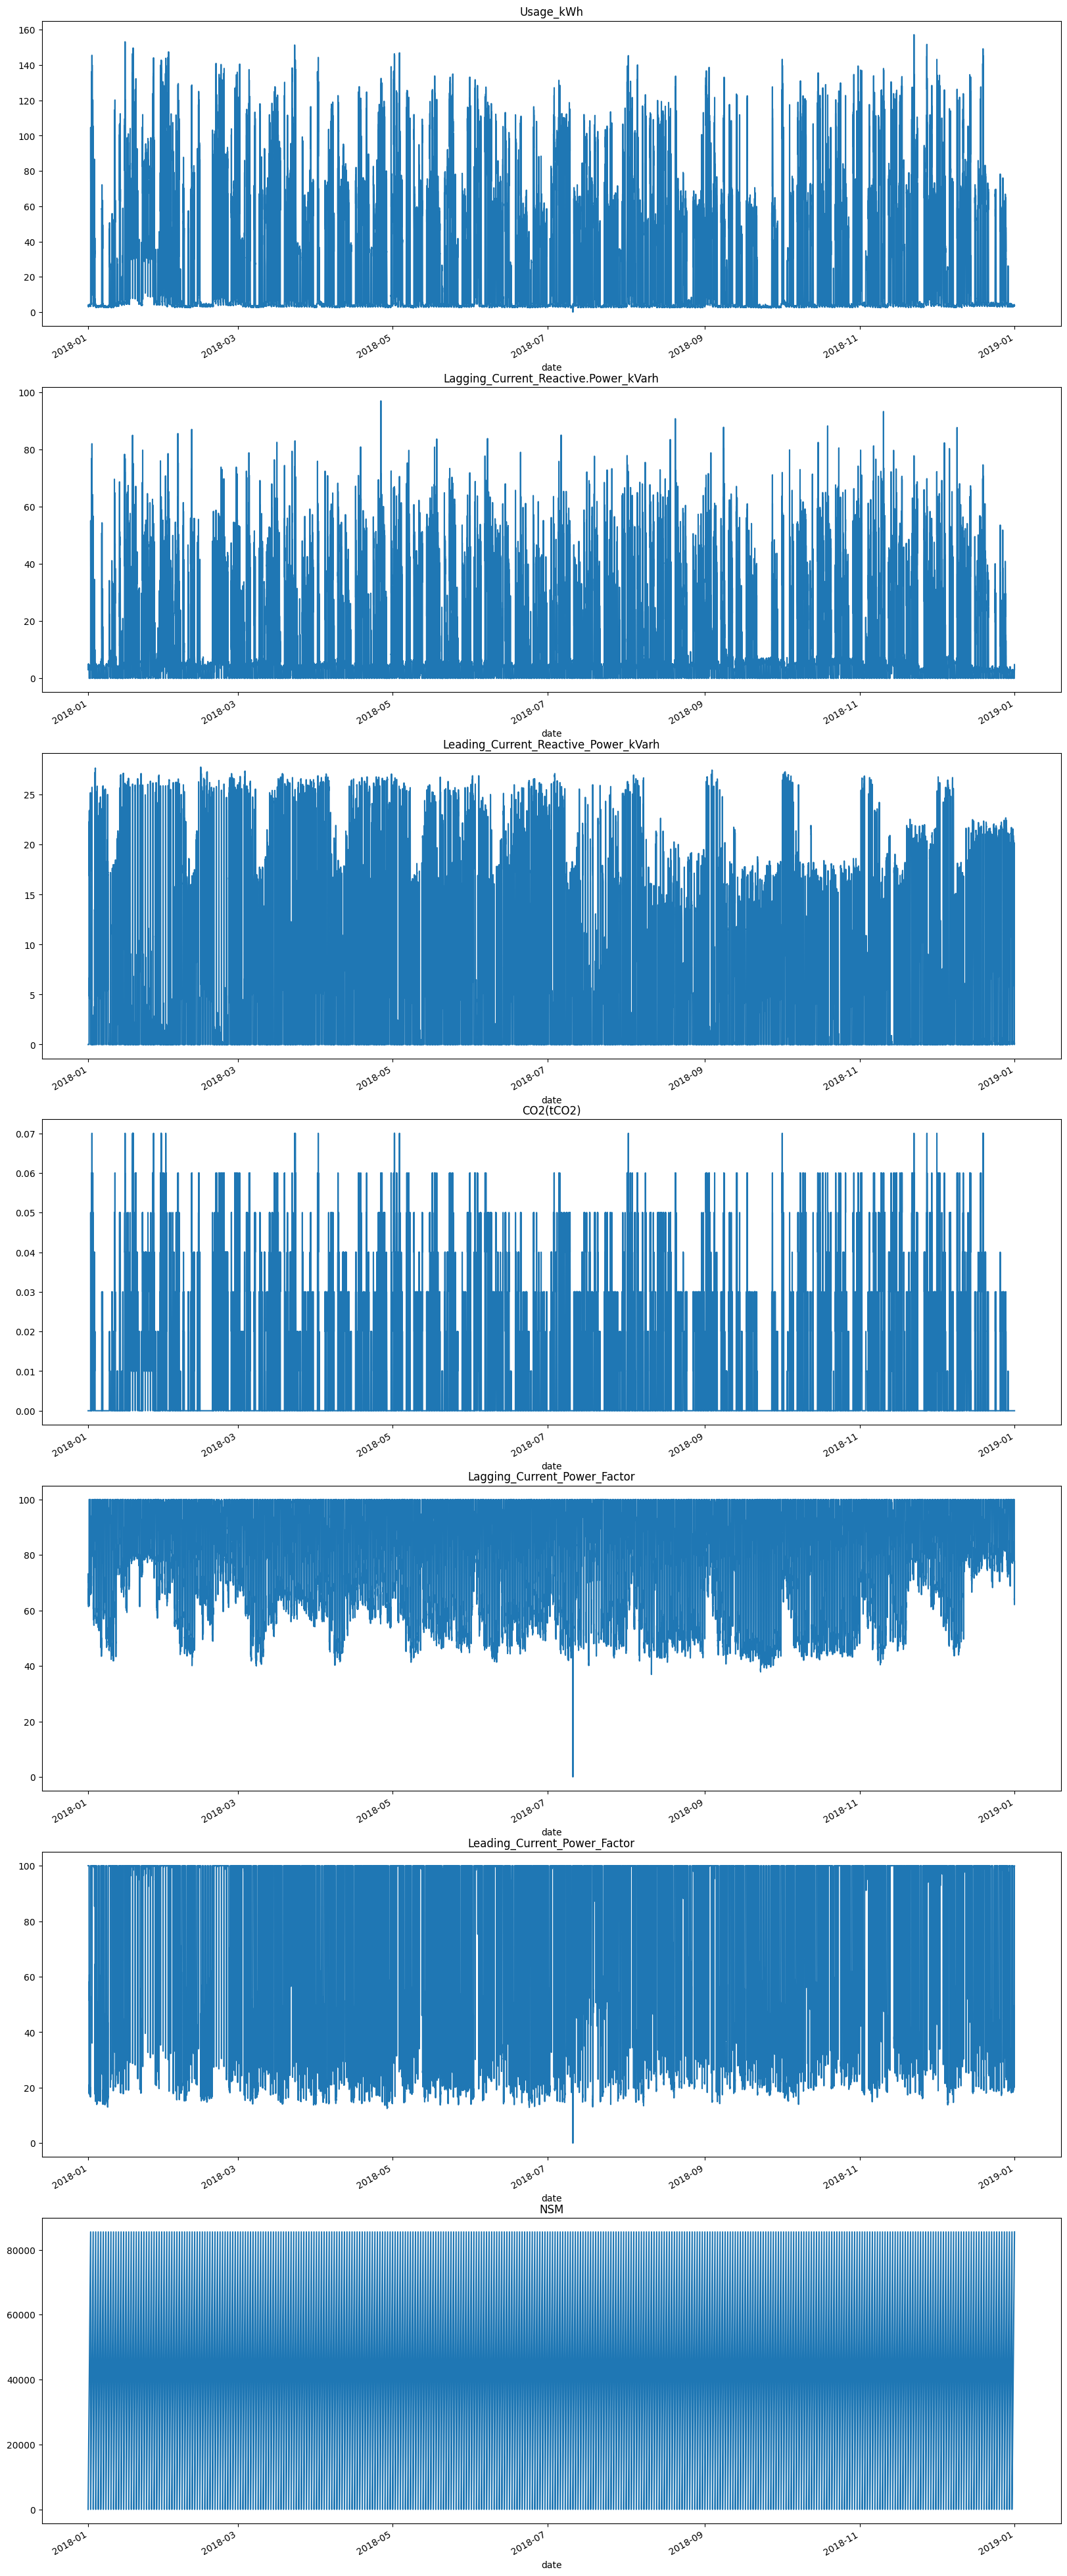

In [23]:
f, ax = plt.subplots(len(numeric_columns), 1, figsize=(20, len(numeric_columns) * 8))
i = 0
for column in numeric_columns:
    df[column].plot(ax=ax[i])
    ax[i].set_title(column)
    i+=1

## Обработка категориальных признаков

In [24]:
for column in tqdm(object_columns):
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

100%|██████████| 3/3 [00:00<00:00, 166.69it/s]


In [25]:
df.head()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
date,,,,,,,,,,
2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,900,0,1,0
2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800,0,1,0
2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700,0,1,0
2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,0,1,0
2018-01-01 01:15:00,3.82,4.50,0.0,0.0,64.72,100.0,4500,0,1,0


In [26]:
df.dtypes

Usage_kWh                               float64
Lagging_Current_Reactive.Power_kVarh    float64
Leading_Current_Reactive_Power_kVarh    float64
CO2(tCO2)                               float64
Lagging_Current_Power_Factor            float64
Leading_Current_Power_Factor            float64
NSM                                       int64
WeekStatus                                int32
Day_of_week                               int32
Load_Type                                 int32
dtype: object

## Корреляции

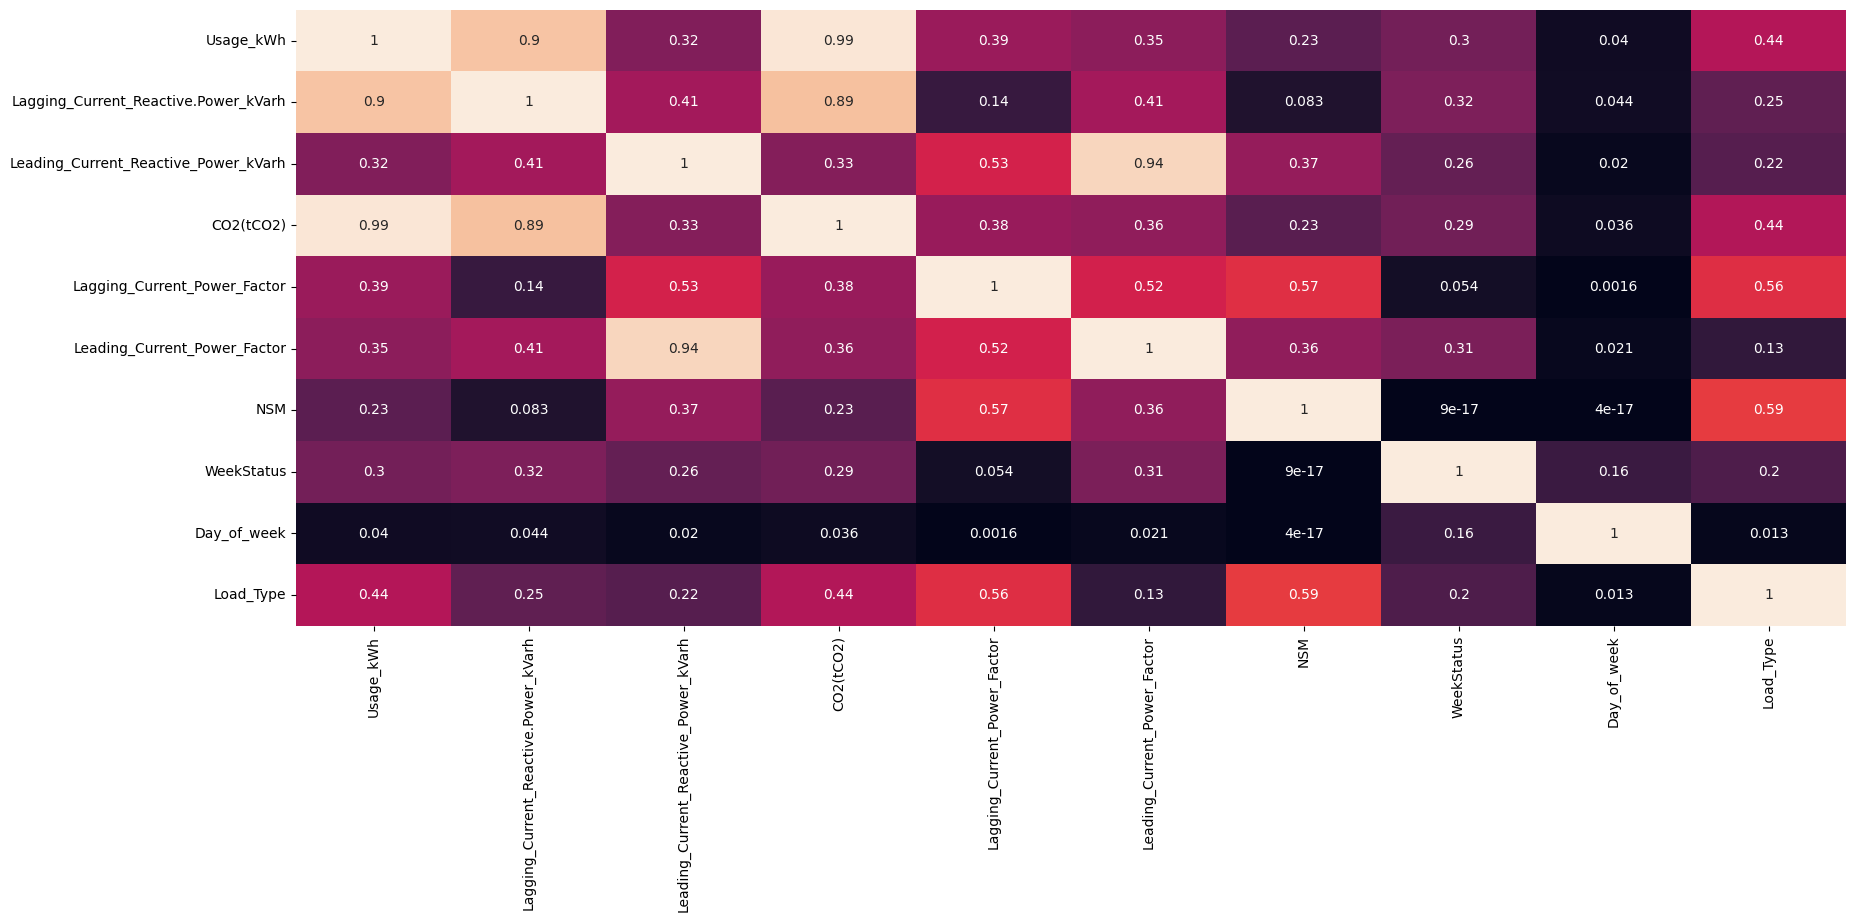

In [27]:
f, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(abs(df.corr()), annot=True, ax=ax, cbar=False)
plt.show()

## Важность признаков

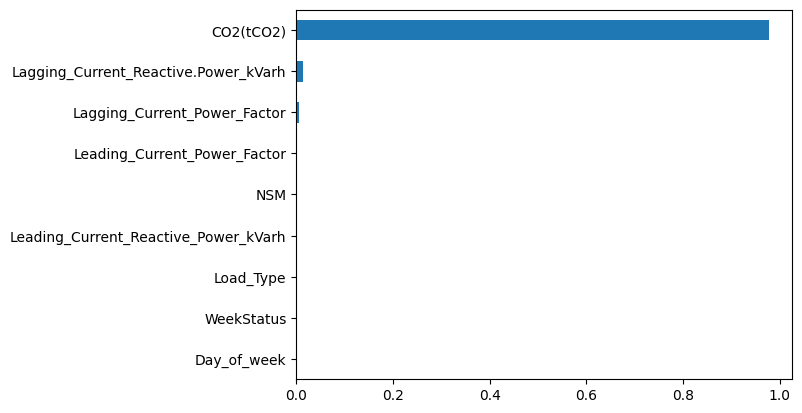

In [28]:
rfc = RandomForestRegressor()
rfc.fit(df.drop(columns=['Usage_kWh']), df['Usage_kWh'])

imp = pd.Series(rfc.feature_importances_, df.drop(columns=['Usage_kWh']).columns[0:len(df.drop(columns=['Usage_kWh']).columns)]).sort_values()
plt.figure()
imp.plot(kind='barh')
plt.show()

## Нормализация

In [29]:
target_scaler = MinMaxScaler()
df['Usage_kWh'] = target_scaler.fit_transform(np.array(df['Usage_kWh']).reshape(-1, 1))

for column in tqdm(df.drop(columns=['Usage_kWh']).columns):
    scaler = MinMaxScaler()
    df[column] = scaler.fit_transform(np.array(df[column]).reshape(-1, 1))

100%|██████████| 9/9 [00:00<00:00, 692.26it/s]


In [30]:
df.head()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
date,,,,,,,,,,
2018-01-01 00:15:00,0.020168,0.030441,0.0,0.0,0.7321,1.0,0.010526,0.0,0.166667,0.0
2018-01-01 00:30:00,0.025449,0.046022,0.0,0.0,0.6677,1.0,0.021053,0.0,0.166667,0.0
2018-01-01 00:45:00,0.020613,0.033846,0.0,0.0,0.7028,1.0,0.031579,0.0,0.166667,0.0
2018-01-01 01:00:00,0.021059,0.036735,0.0,0.0,0.6809,1.0,0.042105,0.0,0.166667,0.0
2018-01-01 01:15:00,0.024303,0.046435,0.0,0.0,0.6472,1.0,0.052632,0.0,0.166667,0.0


In [31]:
params = pd.DataFrame()
params.index = ['Количество', '% пропусков', 'Минимум', 'Среднее', 'Максимум', 'Стандартное отклонение', 'Мощность', 'Первый квартиль', 'Медиана', 'Третий квартиль', 'IQR']
for column in df.columns:
    params[column] = [len(df[column]), df[column].isna().sum() * 100 / len(df[column]), df[column].min(), df[column].mean(), df[column].max(), df[column].std(), df[column].nunique(), df[column].quantile(0.25), df[column].quantile(0.5), df[column].quantile(0.75), df[column].quantile(0.25) - df[column].quantile(0.75)]

params = params.style.apply(lambda x: ["background-color:tomato" if i==1 else "" for i in x], axis=1, subset=(['Мощность'], slice(None))).apply(lambda x: ["background-color:limegreen" if i!=1 else "" for i in x], axis=1, subset=(['Мощность'], slice(None))).apply(lambda x: ["background-color:tomato" if i>=60 else "" for i in x], axis=1, subset=(['% пропусков'], slice(None))).apply(lambda x: ["background-color:steelblue" if i<60 and i >= 30 else "" for i in x], axis=1, subset=(['% пропусков'], slice(None))).apply(lambda x: ["background-color:limegreen" if i<30 else "" for i in x], axis=1, subset=(['% пропусков'], slice(None)))
params

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
Количество,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
% пропусков,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Минимум,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Среднее,0.174239,0.134510,0.139443,0.164632,0.805781,0.843679,0.500000,0.284932,0.499087,0.380479
Максимум,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Стандартное отклонение,0.212778,0.168259,0.267452,0.230726,0.189213,0.304565,0.291702,0.451388,0.333337,0.428762
Мощность,3343.000000,1954.000000,768.000000,8.000000,5079.000000,3366.000000,96.000000,2.000000,7.000000,3.000000
Первый квартиль,0.020359,0.023733,0.000000,0.000000,0.633200,0.997000,0.250000,0.000000,0.166667,0.000000
Медиана,0.029075,0.051594,0.000000,0.000000,0.879600,1.000000,0.500000,0.000000,0.500000,0.000000
Третий квартиль,0.325980,0.233619,0.075288,0.285714,0.990225,1.000000,0.750000,1.000000,0.833333,1.000000


## Разделение датасета для обучения

In [32]:
X = df.drop(columns=['Usage_kWh'])
Y = df['Usage_kWh']

In [33]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)

In [34]:
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()

## Подготовка датасета для рекуррентных сетей

In [35]:
depth = 5

In [36]:
x = []
y = []
for i in tqdm(range(x_train.shape[0] - depth)):
    x.append(x_train[i:i+depth])
    y.append(y_train[i+depth])
x_train = np.array(x)
y_train = np.array(y)

x = []
y = []
for i in tqdm(range(x_test.shape[0] - depth)):
    x.append(x_test[i:i+depth])
    y.append(y_test[i+depth])
x_test = np.array(x)
y_test = np.array(y)

100%|██████████| 10507/10507 [00:00<00:00, 954899.18it/s]


In [37]:
print(f"Train dataset shape: {x_train.shape}, {y_train.shape}")
print(f"Test dataset shape:  {x_test.shape}, {y_test.shape}")

Train dataset shape: (24523, 5, 9), (24523,)
Test dataset shape:  (10507, 5, 9), (10507,)


# Решение

In [38]:
def inverse_transform(arr):
    result = []
    for i in tqdm(range(len(arr))):
        if float(arr[i]) < 0:
            result.append(0.0)
        else:
            result.append(float(arr[i]))
    result = np.array(result)
    result = target_scaler.inverse_transform(result.reshape(-1,1))
    return result

In [39]:
def plot(y_pred, y_true, name, start=0, end=500):
    plt.plot(y_true[start:end], label='true values')
    plt.plot(y_pred[start:end], label='prediction values')
    plt.legend(loc='upper center')
    plt.title(name)

## RNN

In [40]:
rnn_model = Network() 

rnn_model.add(Input(x_train.shape))
rnn_model.add(RNN(50, activation=Tanh))

rnn_model.compile(loss=MSE) 
rnn_model.fit(X_train=x_train, Y_train=y_train, epochs=10, learning_rate=.005) 
rnn_y_pred = rnn_model.predict(X=x_test)

Compilation...


100%|██████████| 1/1 [00:00<?, ?it/s]


Learning...


100%|██████████| 24523/24523 [00:07<00:00, 3106.39it/s]


Epoch 1/10: loss=0.020064357313457213


100%|██████████| 24523/24523 [00:07<00:00, 3126.13it/s]


Epoch 2/10: loss=0.011666510014730543


100%|██████████| 24523/24523 [00:07<00:00, 3111.22it/s]


Epoch 3/10: loss=0.010075257634694865


100%|██████████| 24523/24523 [00:07<00:00, 3157.00it/s]


Epoch 4/10: loss=0.009068678035919472


100%|██████████| 24523/24523 [00:07<00:00, 3114.16it/s]


Epoch 5/10: loss=0.008745402316922378


100%|██████████| 24523/24523 [00:07<00:00, 3149.62it/s]


Epoch 6/10: loss=0.008709689912449036


100%|██████████| 24523/24523 [00:07<00:00, 3107.96it/s]


Epoch 7/10: loss=0.008628858402988666


100%|██████████| 24523/24523 [00:07<00:00, 3099.70it/s]


Epoch 8/10: loss=0.008573989391530524


100%|██████████| 24523/24523 [00:08<00:00, 2911.40it/s]


Epoch 9/10: loss=0.008379942748787356


100%|██████████| 24523/24523 [00:07<00:00, 3084.95it/s]


Epoch 10/10: loss=0.008139144528229994
Prediction...


100%|██████████| 10507/10507 [00:00<00:00, 21140.74it/s]


In [41]:
rnn_y_pred = inverse_transform(rnn_y_pred)

100%|██████████| 10507/10507 [00:00<00:00, 2101452.11it/s]


## GRU

In [42]:
gru_model = Network() 

gru_model.add(Input(x_train.shape))
gru_model.add(GRU(5))

gru_model.compile(loss=MSE) 
gru_model.fit(X_train=x_train, Y_train=y_train, epochs=2, learning_rate=.005) 
gru_y_pred = gru_model.predict(X=x_test)

Compilation...


100%|██████████| 1/1 [00:00<?, ?it/s]


Learning...


100%|██████████| 24523/24523 [00:16<00:00, 1508.93it/s]


Epoch 1/2: loss=0.03248897834885263


100%|██████████| 24523/24523 [00:16<00:00, 1527.21it/s]


Epoch 2/2: loss=0.01854930664363231
Prediction...


100%|██████████| 10507/10507 [00:01<00:00, 5966.50it/s]


In [43]:
gru_y_pred = inverse_transform(gru_y_pred)

100%|██████████| 10507/10507 [00:00<00:00, 1500750.97it/s]


## LSTM

In [44]:
lstm_model = Network() 

lstm_model.add(Input(x_train.shape))
lstm_model.add(LSTM(10))

lstm_model.compile(loss=MSE) 
lstm_model.fit(X_train=x_train, Y_train=y_train, epochs=10, learning_rate=.005) 
lstm_y_pred = lstm_model.predict(X=x_test)

Compilation...


100%|██████████| 1/1 [00:00<00:00, 1001.03it/s]


Learning...


100%|██████████| 24523/24523 [00:17<00:00, 1429.09it/s]


Epoch 1/10: loss=0.04371666557473131


100%|██████████| 24523/24523 [00:17<00:00, 1420.21it/s]


Epoch 2/10: loss=0.030456377351665908


100%|██████████| 24523/24523 [00:17<00:00, 1433.44it/s]


Epoch 3/10: loss=0.0306977595868526


100%|██████████| 24523/24523 [00:16<00:00, 1445.46it/s]


Epoch 4/10: loss=0.028893084845829194


100%|██████████| 24523/24523 [00:17<00:00, 1439.86it/s]


Epoch 5/10: loss=0.024824838171077206


100%|██████████| 24523/24523 [00:16<00:00, 1446.24it/s]


Epoch 6/10: loss=0.021233534975538464


100%|██████████| 24523/24523 [00:16<00:00, 1446.93it/s]


Epoch 7/10: loss=0.025950184795762637


100%|██████████| 24523/24523 [00:16<00:00, 1444.48it/s]


Epoch 8/10: loss=0.019850153670270532


100%|██████████| 24523/24523 [00:17<00:00, 1432.99it/s]


Epoch 9/10: loss=0.018949959367069533


100%|██████████| 24523/24523 [00:17<00:00, 1417.44it/s]


Epoch 10/10: loss=0.015672937069358992
Prediction...


100%|██████████| 10507/10507 [00:02<00:00, 4177.98it/s]


In [45]:
lstm_y_pred = inverse_transform(lstm_y_pred)

100%|██████████| 10507/10507 [00:00<00:00, 1500955.42it/s]


# Результаты

In [46]:
y_test = inverse_transform(y_test)

100%|██████████| 10507/10507 [00:00<00:00, 1501671.45it/s]


## RNN

### История обучения

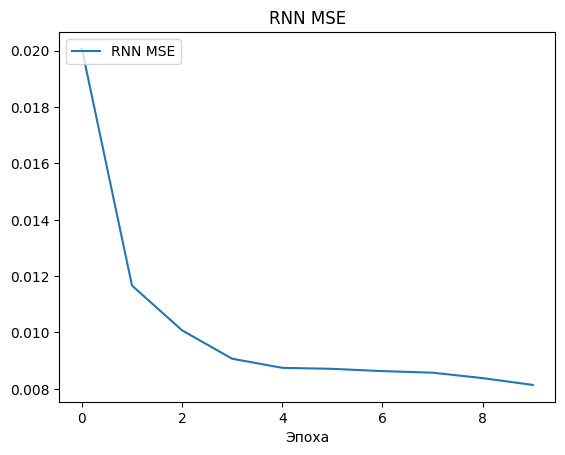

In [47]:
Plot.plot_history_trend(history=rnn_model.history, metric='RNN MSE') 

### Метрики

In [48]:
Metric.print_regression_metrics(y_true=y_test, y_pred=rnn_y_pred)

                
MSE   418.180838
RMSE   20.449470
R^2     0.562347


### График

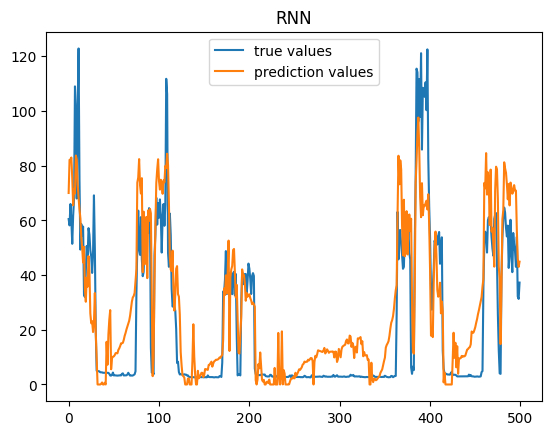

In [49]:
plot(rnn_y_pred, y_test, 'RNN')

## GRU

### История обучения

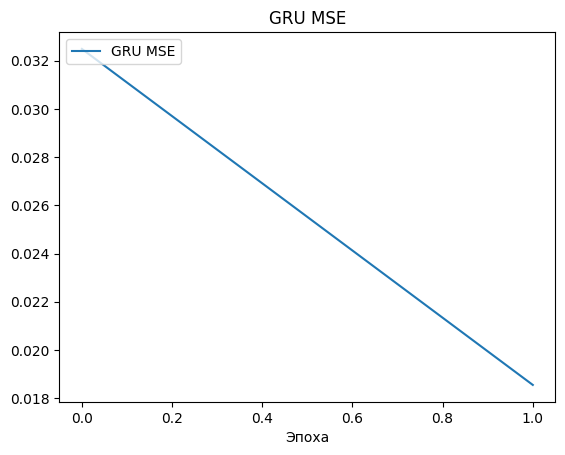

In [50]:
Plot.plot_history_trend(history=gru_model.history, metric='GRU MSE') 

### Метрики

In [51]:
Metric.print_regression_metrics(y_true=y_test, y_pred=gru_y_pred)

                
MSE   353.226973
RMSE   18.794334
R^2     0.630325


### График

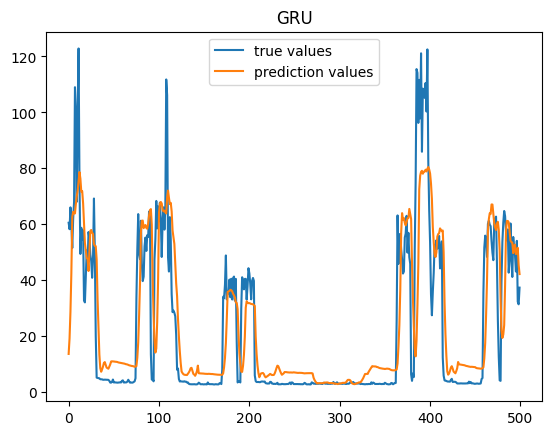

In [52]:
plot(gru_y_pred, y_test, 'GRU')

## LSTM

### История обучения

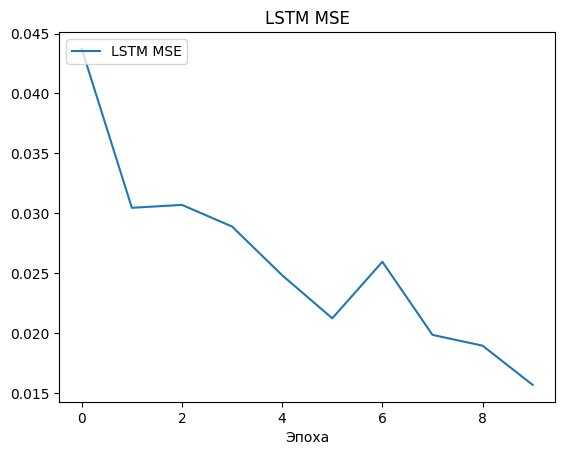

In [53]:
Plot.plot_history_trend(history=lstm_model.history, metric='LSTM MSE') 

### Метрики

In [54]:
Metric.print_regression_metrics(y_true=y_test, y_pred=lstm_y_pred)

                
MSE   282.402600
RMSE   16.804839
R^2     0.704448


### График

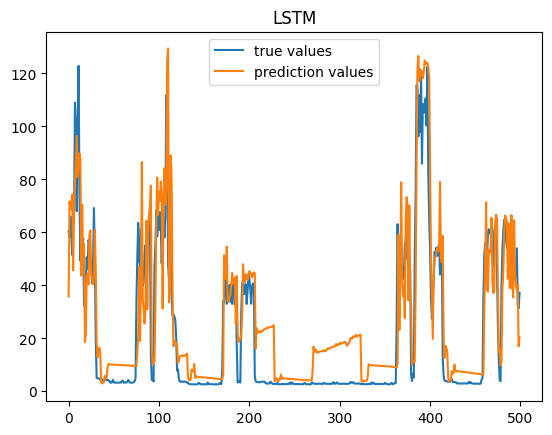

In [55]:
plot(lstm_y_pred, y_test, 'LSTM')